# МФТИ ВШПИ. Домашнее задание 3

## Реализация градиентного бустинга

В рамках этой задачи нужно написать градиентный бустинг над решающими деревьями в задаче классификации. В качестве функции потерь предлагается взять **log loss**. Про рего можно прочитать подробнее здесь: https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss


$y_i$ это правильный ответ (0 или 1), $\hat{y}_i$ это ваше предскзаание

Может показаться, что надо максимизировать функцию $L(\hat{y}, y) = \sum_{i=1}^n y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$, где $y_i$

Да, но нет. Лучше максимизировать функцию $L(\hat{y}, y) = \sum_{i=1}^n y_i \log(f(\hat{y}_i)) + (1 - y_i) \log(1 - f(\hat{y}_i))$, где $f(x) = \frac{1}{1 + e^{-x}}$. Благодаря этому у вас не будет ограничений на принимаеммые значения для $\hat{y}_i$

### Задание 1

Напишите вычисление производной f(x), обычно её называют **сигмоида**.

In [1]:
import numpy as np

In [2]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))


def der_sigmoid(x):
    y = sigmoid(x)
    return y * (1 - y)

In [3]:
der_sigmoid(0) == 0.25

True

In [4]:
der_sigmoid(np.array([0, 0])) == np.array([0.25, 0.25])

array([ True,  True])

In [5]:
der_sigmoid(np.log(3)) == 0.1875

True

**Код для проверки ментором**

In [6]:
print(round(der_sigmoid(np.array([-10, 4.1, -1, 2])).sum() + sigmoid(0.42), 4))

0.9212


Хорошо, теперь мы умеем считать производную функции f, но надо найти производную log loss-а по $\hat{y}$ в первом варианте

Напоминание, первый вариант это  $y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$

### Задание 2

Напишите вычисление производной log loss-a

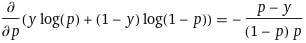

In [7]:
def der_log_loss(y_hat, y_true):
    """
    0 < y_hat < 1
    """
    return -(y_hat - y_true) / (((1 - y_hat) * y_hat))

In [8]:
der_log_loss(0.5, 0) == -2

True

In [9]:
der_log_loss(0.5, 1) == 2

True

In [10]:
der_log_loss(np.array([0.8, 0.8]), np.array([1, 1])) == np.array([1.25, 1.25])

array([ True,  True])

**Код для проверки ментором**

In [11]:
print(round(-sum(der_log_loss((x + 1) / 100., x % 2) for x in range(99)), 2))

69.82


Отлично теперь мы можем воспользоваться производной сложной функции и получить вычисление градиента формулы по второму варианту:

In [12]:
def calc_gradient(y_hat, y_true):
    return der_log_loss(sigmoid(y_hat), y_true) * der_sigmoid(y_hat)

Теперь мы можем написать код градиентного бустинга для классификации

### Задание 3

Допишите класс

In [13]:
from sklearn.base import BaseEstimator # чтобы поддержать интерфейс sklearn
from sklearn.tree import DecisionTreeRegressor # для обучения на каждой итерации

In [14]:
class SimpleGB(BaseEstimator):
    def __init__(self, tree_params_dict, iters=100, tau=1e-1):
        """
        tree_params_dict - словарь параметров, которые надо использовать при обучении дерева на итерации
        iters - количество итераций
        tau - коэффициент перед предсказаниями деревьев на каждой итерации
        """
        self.tree_params_dict = tree_params_dict
        self.iters = iters
        self.tau = tau

    def fit(self, X_data, y_data):
        self.estimators = []
        curr_pred = np.zeros(len(y_data))
        for iter_num in range(self.iters):
            # Нужно найти градиент функции потерь по предсказниям в точке curr_pred
            grad = calc_gradient(curr_pred, y_data)
            # Мы максимизируем, поэтому надо обучить DecisionTreeRegressor с параметрами
            # tree_params_dict по X_data предсказывать grad
            algo = DecisionTreeRegressor(**self.tree_params_dict).fit(X=X_data, y=grad)
            self.estimators.append(algo)
            # все предсказания домножаются на tau и обновляется переменная curr_pred
            curr_pred += self.tau * algo.predict(X_data)

    def predict(self, X_data):
        # изначально все предскзания нули
        res = np.zeros(X_data.shape[0])
        for estimator in self.estimators:
            # нужно сложить все предсказания деревьев с весом self.tau
            res += self.tau * estimator.predict(X_data)

        return (res > 0).astype(int)

## Проверка качества полученного класса (в самом низу код для для проверки ментором)

Можете поиграться с параметрами, посмотрим, у кого самое лучшее качество получится

In [15]:
# для оценки качества
from sklearn.model_selection import cross_val_score

# для генерации датасетов
from sklearn.datasets import make_classification

# для сравнения
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [16]:
X_data, y_data = make_classification(n_samples=1000, n_features=10, random_state=42)

In [17]:
algo = SimpleGB(
    tree_params_dict={
        'max_depth':4
    },
    iters=100,
    tau = 0.1
)

In [18]:
np.mean(cross_val_score(algo, X_data, y_data, cv=5, scoring='accuracy'))

0.921

In [19]:
np.mean(cross_val_score(DecisionTreeClassifier(), X_data, y_data, cv=5, scoring='accuracy'))

0.85

In [20]:
np.mean(cross_val_score(XGBClassifier(), X_data, y_data, cv=5, scoring='accuracy'))

0.907

In [21]:
np.mean(cross_val_score(LogisticRegression(), X_data, y_data, cv=5, scoring='accuracy'))

0.8560000000000001

**Код для проверки ментором**

In [23]:
from sklearn.model_selection import StratifiedKFold

print(round(np.mean(cross_val_score(SimpleGB(
    tree_params_dict={
        'max_depth': 4
    },
    iters=1000,
    tau = 0.01
), X_data, y_data, cv=StratifiedKFold(4, random_state=42, shuffle=True), scoring='accuracy')), 3))

0.921


Все сделано! Кто молодец? Я - молодец.